In [1]:
import sys
!{sys.executable} -m pip install deap


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from deap import base, creator, tools, algorithms
import random

# Load dataset (using the JM1 dataset as an example)
data = pd.read_csv('./kc1.csv')

# Drop any missing values
data = data.dropna()

# Separate features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [3]:
# Define the evaluation function for the Genetic Algorithm
def evalFeatureSelection(individual):
    selected_features = [i for i, val in enumerate(individual) if val == 1]
    if len(selected_features) == 0:
        return (0,)
    
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    
    clf = SVC()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    return (accuracy,)

In [4]:
# Set up the Genetic Algorithm using DEAP

# Create the types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Register the functions
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalFeatureSelection)



In [5]:
# Run the Genetic Algorithm for feature selection:
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	min     	max     
0  	50    	0.842148	0.840442	0.848341
1  	27    	0.844076	0.840442	0.849921
2  	34    	0.845245	0.835703	0.849921
3  	31    	0.846003	0.838863	0.851501
4  	26    	0.846825	0.838863	0.851501
5  	33    	0.847804	0.840442	0.851501
6  	26    	0.849447	0.843602	0.851501
7  	38    	0.849763	0.842022	0.851501
8  	25    	0.850427	0.840442	0.851501
9  	29    	0.850616	0.840442	0.853081
10 	28    	0.8509  	0.840442	0.853081
11 	25    	0.851027	0.840442	0.853081
12 	24    	0.851627	0.843602	0.853081
13 	30    	0.851754	0.845182	0.853081
14 	36    	0.852227	0.843602	0.853081
15 	30    	0.852575	0.840442	0.853081
16 	37    	0.852417	0.843602	0.853081
17 	23    	0.852575	0.845182	0.853081
18 	26    	0.851848	0.840442	0.853081
19 	33    	0.852354	0.840442	0.853081
20 	34    	0.852512	0.840442	0.853081


In [6]:
# Train and evaluate the Naive Bayes classifier using the best feature subset found:
best_individual = hof[0]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print("Best individual: ", best_individual)
print("Number of selected features: ", len(selected_features))

Best individual:  [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]
Number of selected features:  8


In [7]:
# Train the classifier
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = SVC(probability=True)
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.8530805687203792
              precision    recall  f1-score   support

       False       0.86      0.99      0.92       533
        True       0.67      0.14      0.23       100

    accuracy                           0.85       633
   macro avg       0.76      0.56      0.58       633
weighted avg       0.83      0.85      0.81       633



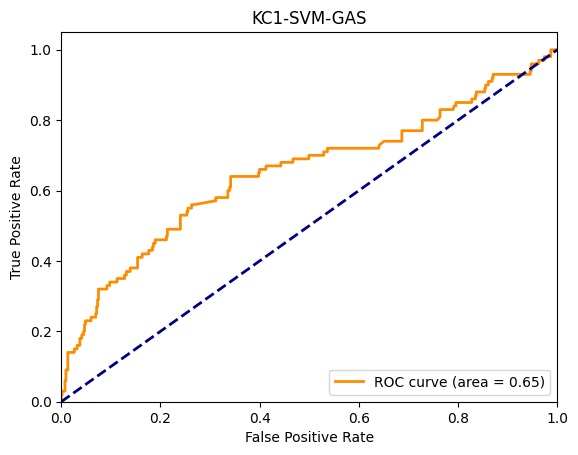

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./AUC_Extracts/KC1/KC1_SVM_GAS.csv', index=False)

# Plot
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KC1-SVM-GAS')
plt.legend(loc="lower right")
plt.show()